In [94]:
import zipfile, os

# ZIP dosyanızı proje klasörüne koyduğunuzdan emin olun
ZIP_PATH = "my_ecg_data.zip"
DATA_DIR = "data/my_ecg_data"

# 1. ZIP’i aç
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall("data")

# 2. Dosya/hasta dizinlerini listele
patients = sorted(d for d in os.listdir(DATA_DIR) if d.startswith("patient"))
print(f"Bulunan hastalar ({len(patients)}):", patients)

Bulunan hastalar (290): ['patient001', 'patient002', 'patient003', 'patient004', 'patient005', 'patient006', 'patient007', 'patient008', 'patient009', 'patient010', 'patient011', 'patient012', 'patient013', 'patient014', 'patient015', 'patient016', 'patient017', 'patient018', 'patient019', 'patient020', 'patient021', 'patient022', 'patient023', 'patient024', 'patient025', 'patient026', 'patient027', 'patient028', 'patient029', 'patient030', 'patient031', 'patient032', 'patient033', 'patient034', 'patient035', 'patient036', 'patient037', 'patient038', 'patient039', 'patient040', 'patient041', 'patient042', 'patient043', 'patient044', 'patient045', 'patient046', 'patient047', 'patient048', 'patient049', 'patient050', 'patient051', 'patient052', 'patient053', 'patient054', 'patient055', 'patient056', 'patient057', 'patient058', 'patient059', 'patient060', 'patient061', 'patient062', 'patient063', 'patient064', 'patient065', 'patient066', 'patient067', 'patient068', 'patient069', 'patient0

In [211]:
def get_diagnosis_from_hea(record_path):
    with open(record_path + ".hea", "r") as f:
        lines = f.readlines()
    for line in lines:
        line = line.strip().lower()
        if "reason for admission" in line or "diagnosis" in line:
            return line.split(":")[-1].strip()
    return "Unknown"

diagnoses = []
for patient in patients:
    folder_path = os.path.join(DATA_DIR, patient)
    files = [f for f in os.listdir(folder_path) if f.endswith(".hea")]
    if not files:
        continue
    first_file = files[0].replace(".hea", "")
    record_path = os.path.join(folder_path, first_file)
    diagnosis = get_diagnosis_from_hea(record_path)
    diagnoses.append({"patient": patient, "diagnosis": diagnosis})

diagnosis_df = pd.DataFrame(diagnoses)
print(diagnosis_df.head())


      patient              diagnosis
0  patient001  myocardial infarction
1  patient002  myocardial infarction
2  patient003  myocardial infarction
3  patient004  myocardial infarction
4  patient005  myocardial infarction


In [212]:
from scipy.stats import kurtosis, skew

def extract_features(record_path):
    try:
        record = wfdb.rdrecord(record_path)
        data = record.p_signal
        features = {}
        for i, channel in enumerate(data.T[:12]):  # ilk 12 kanal
            filtered = bandpass_filter(channel)

            # Temel istatistikler
            features[f'ch{i}_mean'] = np.mean(filtered)
            features[f'ch{i}_median'] = np.median(filtered)
            features[f'ch{i}_std'] = np.std(filtered)
            features[f'ch{i}_max'] = np.max(filtered)
            features[f'ch{i}_min'] = np.min(filtered)

            # Gelişmiş öznitelikler
            features[f'ch{i}_rms'] = np.sqrt(np.mean(filtered**2))                # RMS
            features[f'ch{i}_skew'] = skew(filtered)                              # Skewness
            features[f'ch{i}_kurtosis'] = kurtosis(filtered)                      # Kurtosis
            features[f'ch{i}_range'] = np.max(filtered) - np.min(filtered)        # Range
            features[f'ch{i}_zcr'] = ((filtered[:-1] * filtered[1:]) < 0).sum()   # Zero Crossing Rate

        return features
    except Exception as e:
        print(f"HATA ({record_path}):", e)
        return None

In [213]:
from scipy.signal import butter, filtfilt

def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=1000, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)


In [214]:
from collections import Counter

feature_list = []

for row in diagnoses:
    patient = row['patient']
    folder_path = os.path.join(DATA_DIR, patient)
    files = [f for f in os.listdir(folder_path) if f.endswith(".dat")]
    if not files:
        continue
    first_file = files[0].replace(".dat", "")
    record_path = os.path.join(folder_path, first_file)

    features = extract_features(record_path)
    if features:
        features["diagnosis"] = row["diagnosis"]
        features["patient"] = patient
        feature_list.append(features)

df = pd.DataFrame(feature_list)

# Tanıları etiketle
def simplify_diagnosis(text):
    text = text.lower()
    if "myocardial infarction" in text:
        return "MI"
    elif "heart failure" in text or "nyha" in text or "cardiomyopathy" in text:
        return "Heart Failure"
    elif "healthy" in text:
        return "Healthy"
    elif "block" in text:
        return "Block"
    elif "myocarditis" in text:
        return "Myocarditis"
    elif "dysrhythmia" in text:
        return "Dysrhythmia"
    elif "hypertrophy" in text:
        return "Hypertrophy"
    elif "valvular heart disease" in text:
        return "Valvular Disease"
    elif "angina" in text:
        if "unstable" in text:
            return "Unstable Angina"
        elif "stable" in text:
            return "Stable Angina"
        else:
            return "Angina"
    elif "palpitation" in text:
        return "Palpitation"
    elif "n/a" in text or text.strip() in ["", "unknown"]:
        return "Unknown"
    else:
        return "Other"

df["label"] = df["diagnosis"].apply(simplify_diagnosis)

# Az sınıfları çıkar
class_counts = Counter(df["label"])
df = df[df["label"].isin([label for label, count in class_counts.items() if count >= 2])]

In [215]:
from scipy.signal import find_peaks
def extract_advanced_ecg_features(signal, fs=1000):
    """
    ECG sinyali üzerinden QRS süresi, RR aralığı, PR aralığı gibi özellikleri çıkarır.
    """
    features = {}

    # normalize et
    signal = (signal - np.mean(signal)) / np.std(signal)

    # R peak'lerini bul (QRS'nin ortası)
    r_peaks, _ = find_peaks(signal, distance=fs*0.4, height=0.5)  # ~0.4s'de bir kalp atımı
    if len(r_peaks) < 2:
        return None  # yeterli peak yoksa çıkarma

    # RR interval (ms)
    rr_intervals = np.diff(r_peaks) * 1000 / fs  # saniyeden ms’ye
    features["rr_mean"] = np.mean(rr_intervals)
    features["rr_std"] = np.std(rr_intervals)

    # QRS süresi tahmini: her R peak etrafında sinyalin genişliği
    qrs_durations = []
    for r in r_peaks:
        window = signal[max(r - int(0.1*fs), 0):r + int(0.1*fs)]
        qrs_width = len(window[window > 0.5]) * 1000 / fs  # ms
        qrs_durations.append(qrs_width)
    features["qrs_mean"] = np.mean(qrs_durations)

    # PR aralığı tahmini: P dalgası R'den önceki küçük yükseliş
    pr_intervals = []
    for r in r_peaks:
        search_window = signal[max(r - int(0.3*fs), 0):r]
        p_peaks, _ = find_peaks(search_window, height=0.2)
        if len(p_peaks) > 0:
            pr = (r - (r - len(search_window) + p_peaks[-1])) * 1000 / fs
            pr_intervals.append(pr)
    if pr_intervals:
        features["pr_mean"] = np.mean(pr_intervals)

    # T dalgası R'den sonra gelen tepe
    t_intervals = []
    for r in r_peaks:
        post_r = signal[r + int(0.2*fs):r + int(0.6*fs)]
        t_peaks, _ = find_peaks(post_r, height=0.2)
        if len(t_peaks) > 0:
            t_intervals.append(t_peaks[0] * 1000 / fs)
    if t_intervals:
        features["t_mean_time"] = np.mean(t_intervals)

    return features

In [216]:
from scipy.stats import kurtosis, skew

def extract_features(record_path):
    try:
        record = wfdb.rdrecord(record_path)
        data = record.p_signal
        features = {}
        for i, channel in enumerate(data.T[:12]):  # ilk 12 kanal
            filtered = bandpass_filter(channel)
            if i == 0:
                adv_features = extract_advanced_ecg_features(filtered)
                if adv_features:
                    features.update(adv_features)

            # Temel istatistikler
            features[f'ch{i}_mean'] = np.mean(filtered)
            features[f'ch{i}_median'] = np.median(filtered)
            features[f'ch{i}_std'] = np.std(filtered)
            features[f'ch{i}_max'] = np.max(filtered)
            features[f'ch{i}_min'] = np.min(filtered)

            # Gelişmiş öznitelikler
            features[f'ch{i}_rms'] = np.sqrt(np.mean(filtered**2))                # RMS
            features[f'ch{i}_skew'] = skew(filtered)                              # Skewness
            features[f'ch{i}_kurtosis'] = kurtosis(filtered)                      # Kurtosis
            features[f'ch{i}_range'] = np.max(filtered) - np.min(filtered)        # Range
            features[f'ch{i}_zcr'] = ((filtered[:-1] * filtered[1:]) < 0).sum()   # Zero Crossing Rate

        return features
    except Exception as e:
        print(f"HATA ({record_path}):", e)
        return None


In [217]:
feature_list = []
for row in diagnoses:
    patient = row['patient']
    folder_path = os.path.join(DATA_DIR, patient)
    files = [f for f in os.listdir(folder_path) if f.endswith(".dat")]
    if not files:
        continue
    first_file = files[0].replace(".dat", "")
    record_path = os.path.join(folder_path, first_file)
    features = extract_features(record_path)
    if features:
        features["diagnosis"] = row["diagnosis"]
        features["patient"] = patient
        feature_list.append(features)

df = pd.DataFrame(feature_list)
df = df.dropna()


In [218]:
print(df['diagnosis'].value_counts())

diagnosis
myocardial infarction     139
healthy control            49
n/a                        20
dysrhythmia                14
bundle branch block        13
cardiomyopathy             12
valvular heart disease      6
hypertrophy                 5
myocarditis                 3
stable angina               2
heart failure (nyha 3)      1
heart failure (nyha 2)      1
heart failure (nyha 4)      1
unstable angina             1
Name: count, dtype: int64


In [219]:
from collections import Counter

def simplify_diagnosis(text):
    text = text.lower()
    if "myocardial infarction" in text:
        return "MI"
    elif "heart failure" in text or "nyha" in text or "cardiomyopathy" in text:
        return "Heart Failure"
    elif "healthy" in text:
        return "Healthy"
    elif "block" in text:
        return "Block"
    elif "myocarditis" in text:
        return "Myocarditis"
    elif "dysrhythmia" in text:
        return "Dysrhythmia"
    elif "hypertrophy" in text:
        return "Hypertrophy"
    elif "valvular heart disease" in text:
        return "Valvular Disease"
    elif "angina" in text:
        if "unstable" in text:
            return "Unstable Angina"
        elif "stable" in text:
            return "Stable Angina"
        else:
            return "Angina"
    elif "palpitation" in text:
        return "Palpitation"
    elif "n/a" in text or text.strip() in ["", "unknown"]:
        return "Unknown"
    else:
        return "Other"

df["label"] = df["diagnosis"].apply(simplify_diagnosis)

class_counts = Counter(df["label"])
df = df[df["label"].isin([label for label, count in class_counts.items() if count >= 2])]

In [220]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df.drop(columns=["diagnosis", "label", "patient"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))


                  precision    recall  f1-score   support

           Block       0.00      0.00      0.00         3
     Dysrhythmia       0.00      0.00      0.00         3
         Healthy       1.00      0.80      0.89        10
   Heart Failure       0.00      0.00      0.00         3
     Hypertrophy       0.00      0.00      0.00         1
              MI       0.62      1.00      0.77        28
     Myocarditis       0.00      0.00      0.00         1
         Unknown       0.00      0.00      0.00         4
Valvular Disease       0.00      0.00      0.00         1

        accuracy                           0.67        54
       macro avg       0.18      0.20      0.18        54
    weighted avg       0.51      0.67      0.56        54



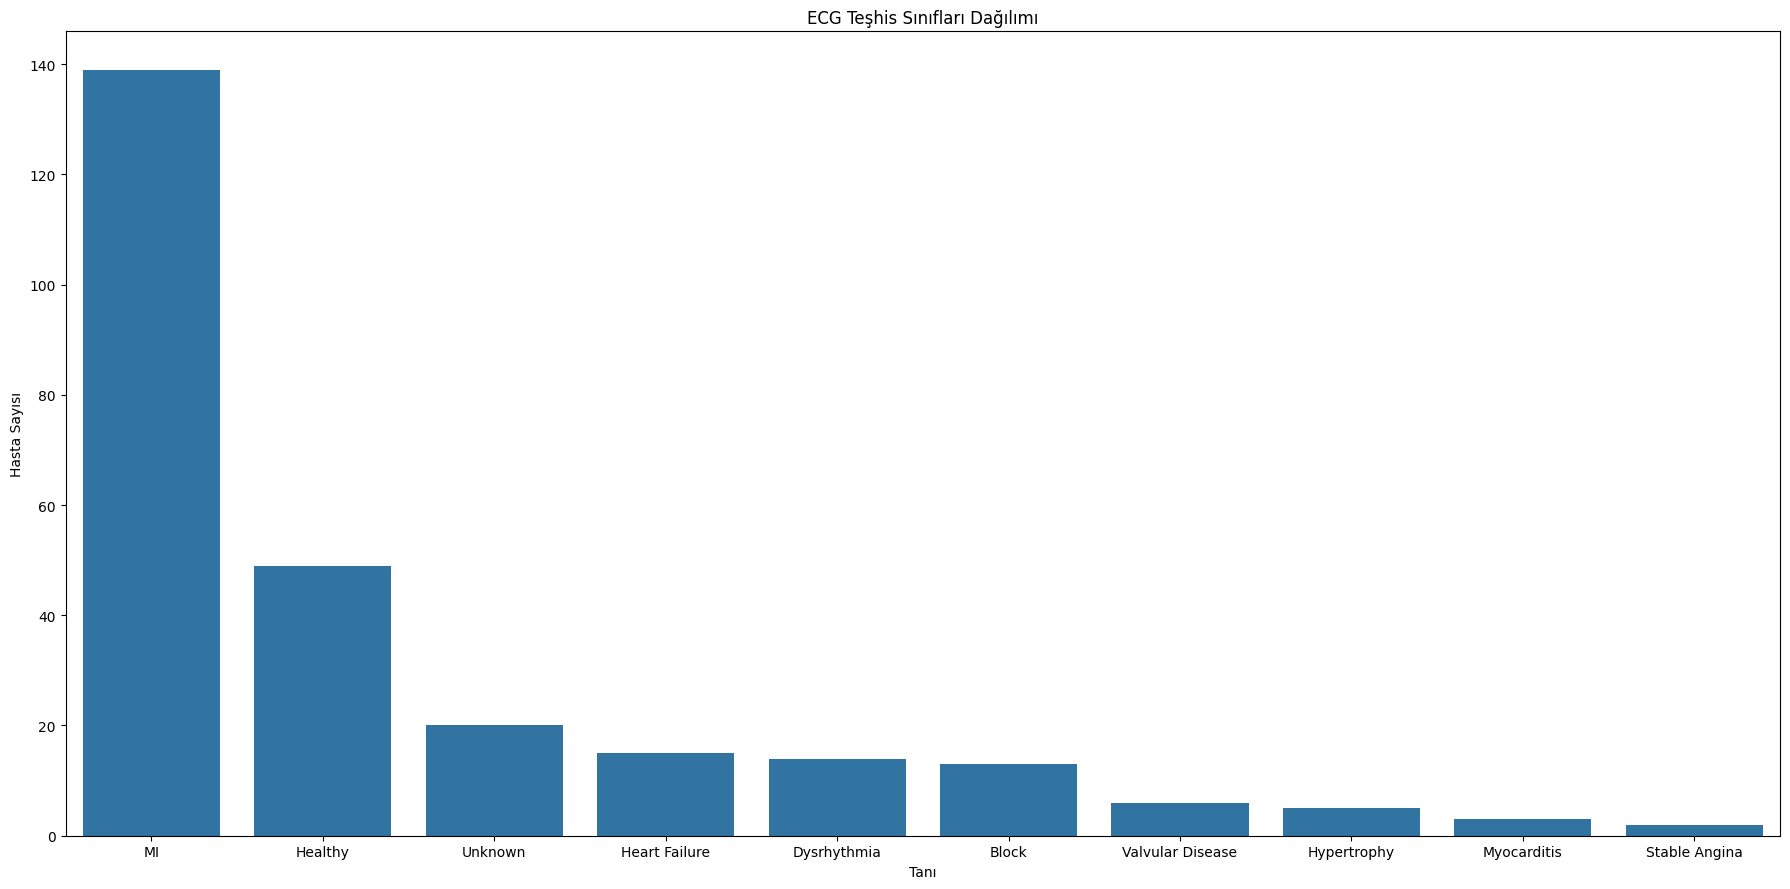

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 9))
sns.countplot(data=df, x="label", order=df["label"].value_counts().index)
plt.title("ECG Teşhis Sınıfları Dağılımı")
plt.xlabel("Tanı")
plt.ylabel("Hasta Sayısı")
plt.tight_layout()
plt.show()

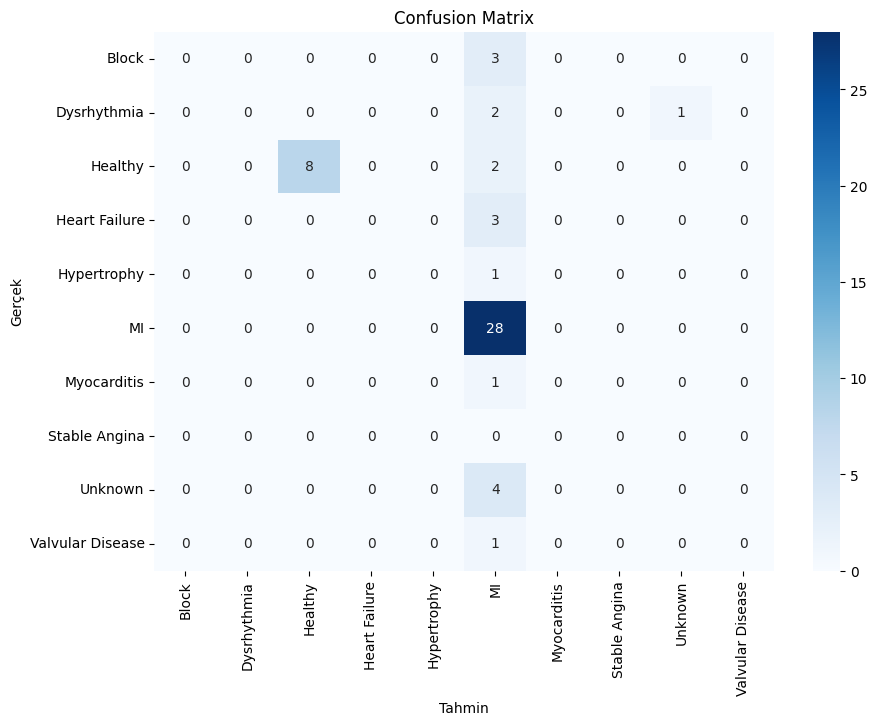

In [222]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.show()

In [223]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# accuracy
acc = accuracy_score(y_test, y_pred)

# macro (tüm sınıflar eşit önemdeymiş gibi)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print("🔍 Model Değerlendirme Metrikleri")
print(f"Accuracy     : {acc:.4f}")
print(f"Precision (macro avg): {precision:.4f}")
print(f"Recall   (macro avg): {recall:.4f}")
print(f"F1 Score (macro avg): {f1:.4f}")

🔍 Model Değerlendirme Metrikleri
Accuracy     : 0.6667
Precision (macro avg): 0.1802
Recall   (macro avg): 0.2000
F1 Score (macro avg): 0.1840
